In [1]:
%matplotlib inline

In [2]:
!hostname

mum-hpc2-gpu2


In [3]:
%cd ICRA_2023

/home/ssap0002/ICRA_2023


In [4]:
from VRNN_DAT import VRNN_DAT
from RNN import GRU, LSTM
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

2022-09-18 13:42:48.023232: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Loading

In [5]:
import os
import numpy as np
import pickle5 as pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ORI_DATA_DIR = 'data/gripper/full'
HALF_DATA_DIR = 'data/gripper/half'
SYNTH_DATA_DIR = 'output/'

In [6]:
def to_timeseries(X, y, time_steps = 50):
    dataX = []
    dataY = []
    # Cut data by sequence length
    for i in range(0, len(X) - time_steps):
        _x = X[i:i+time_steps, :]
        _y = y[i:i+time_steps, :]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

def revert_timeseries(X, time_steps = 100):
  # if len(X[0]) == time_steps and time_steps != 1:
  #   return np.array(X[0])
  head = X[0]
  tail = np.array([f[time_steps-1] for f in X])
  return np.concatenate((head, tail))

def load_pickle(filepath):
    with open(filepath,'rb') as f:
      x = pickle.load(f)
      return x
    
def _preprocess(data):
  # Features
  flex = data['Flex'][0]
  pressure = data['Pressure'][0]

  # Labels
  f1, f2 = data['Force']
  x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = data['PosX']
  y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 = data['PosY']
      
  x = list(zip(flex, pressure, f1, f2, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))
  return np.array(x)

def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def load_data(s, _from='Train', scaler=None):
  raw_data = load_pickle("data/new_soro_all.pkl")
  train = raw_data.xs(_from, axis=0, level=1, drop_level=True)

  raw_data = _preprocess(train[s])

  # Normalize 
  if scaler is None:
      label_scaler = MinMaxScaler(clip=True)
      feature_scaler = MinMaxScaler(clip=True)
    
      features, labels = feature_scaler.fit_transform(raw_data[:, :2]), label_scaler.fit_transform(raw_data[:, 2:])
      print(f"creating scaler from {s}")
      
  else:
    print("reusing scaler")
    label_scaler, feature_scaler = scaler
    features, labels = feature_scaler.transform(raw_data[:, :2]), label_scaler.transform(raw_data[:, 2:])
    

  # Timeseries
  X_train, y_train = to_timeseries(features, labels, params['timesteps'])

  return  X_train, y_train, (label_scaler, feature_scaler)

In [7]:
def load_dataset(datatype, datasets, batch_size, no_state_data=[], scaler=None):
    X_train, y_train, domain_labels = [], [], []
    
    if datatype == 'test':
        for scenario in datasets:
            if params['TEST'] == scenario:
                _x, _y, scaler = load_data(scenario, _from='Test', scaler=scaler)
                X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
                print(len(_x))
                if scenario in no_state_data:
                    domain_labels.append([0 for _ in range(len(_x))])
                else:
                    domain_labels.append([1 for _ in range(len(_x))])

        for i, (x,y) in enumerate(zip(X_train, y_train)):
            if i == 0:
                dataset = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                dataset = dataset.batch(batch_size)
            
            else: 
                _d = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                _d = _d.batch(batch_size)
                dataset = dataset.concatenate(_d)
        return dataset, scaler
    
    elif datatype == 'train':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Train', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        Xdata = np.concatenate(X_train)
        ydata = np.concatenate(y_train)
        Statedata = np.concatenate(domain_labels).astype(np.float32)

        # Shuffle
        p = np.random.permutation(len(Xdata))
        Xdata = Xdata[p]
        ydata = ydata[p]
        Statedata = Statedata[p]

        dataset =  tf.data.Dataset.from_tensor_slices((Xdata ,ydata, Statedata))
        return dataset.batch(batch_size), scaler


In [8]:
def get_dataset(model_type, train_scenario, batch_size, test_source=False):
    
    if train_scenario == "tip_contact":        
        all_datasets = ['osc_tip_30', 'osc_rand_30', 'rand_tip_30', 'rand_rand_60']
    elif train_scenario == "random_contact":
        all_datasets = ['osc_rand_30', 'rand_rand_60','osc_tip_30', 'rand_tip_30']
    elif train_scenario == "osc":        
        all_datasets = ['osc_tip_30', 'osc_rand_30', 'rand_tip_30', 'rand_rand_60']
    elif train_scenario == "rand":
        all_datasets = ['rand_tip_30', 'rand_rand_60', 'osc_tip_30', 'osc_rand_30']
    
        
    if train_scenario == "tip_contact":
        _train_d = ['osc_tip_30', 'rand_tip_30']
    elif train_scenario == "random_contact":
        _train_d = ['osc_rand_30', 'rand_rand_60']
    elif train_scenario == "osc":
        _train_d = ['osc_tip_30', 'osc_rand_30']
    elif train_scenario == "rand":
        _train_d = ['rand_tip_30', 'rand_rand_60']
    
    if test_source:
        _test_d = _train_d
        
    else:
        _test_d = [d for d in all_datasets if d not in _train_d]
    
        
    if model_type == "GRU" or model_type == "LSTM":           
        train_dataset, scaler = load_dataset('train', _train_d, batch_size)
    
    elif "VRNN_DAT" in model_type:
        train_dataset, scaler = load_dataset('train', all_datasets, batch_size, no_state_data=_test_d)
        
    test_dataset, _ = load_dataset('test', _test_d, batch_size, scaler=scaler)
    
    return train_dataset, test_dataset, scaler

def get_model(model_type, params=None):
    if model_type == "GRU":
        return GRU(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "LSTM":
        return LSTM(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "VRNN":
        pass
    elif "VRNN_DAT" in model_type:
        return VRNN_DAT(params['x_dim'], params['h_dim'], params['z_dim'], phi_x_dim=params['phi_x_dim'], d_dim=params['d_dim'], vrnn_lr=params['lr'], adv_lr=params['adv_lr'], clip=params['clip'], rnn=params['rnn'])

def evaluate_model(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)
    
    # force_x_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    # force_z_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    force_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    marker_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    rmse_metric =  tf.keras.metrics.RootMeanSquaredError()
    
    # force_x_rmse_metric.update_state(y_test[:, :, 0], pred[:, :, 0]).numpy()
    # force_z_rmse_metric.update_state(y_test[:, :, 1], pred[:, :, 1]).numpy()
    force_rmse_metric.update_state(y_test[:, :, :2], pred[:, :, :2]).numpy()
    force_rmse = force_rmse_metric.result().numpy()

    marker_rmse_metric.update_state(y_test[:, :, 2:], pred[:, :, 2:]).numpy()
    marker_rmse = marker_rmse_metric.result().numpy()
    
    rmse_metric.update_state(y_test, pred).numpy()
    rmse =  rmse_metric.result().numpy()
    
    return rmse, force_rmse, marker_rmse

## Hyperparameters

In [9]:
x_dim = 2 # flex + pressure
h_dim = 128
z_dim = 22 # 2 force + 10*2D coordinates
phi_x_dim = 32
d_dim = 128
n_epochs = 50
clip = 5
lr = 1e-3
adv_lr = 1e-3
batch_size = 128 # 32
seed = 261199
timesteps=100
rnn="GRU"
# tf.random.set_seed(seed)

In [10]:
from sorcery import dict_of

params = dict_of(x_dim, h_dim, z_dim, phi_x_dim, timesteps, d_dim, n_epochs, clip, lr, adv_lr, batch_size, rnn)

## Load Models

In [11]:
def load_model(model_type, train_scenario, run=3):
    print(f"================={model_type}:{train_scenario}:{run}==================")
    # Prepare dataset and model
    model = get_model(model_type, params)

    # Train
    if model_type == "GRU" or model_type == "LSTM":
        model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.RootMeanSquaredError()])
    else:
        model.compile()

    # Save weights
    model.load_weights(f"weights/one_scaler/dat_z/{model_type}/{train_scenario}/run_{run}/")
    print("loaded model")
    
#     # Evaluate
#     (force_x_rmse, force_z_rmse), marker_rmse = evaluate_model(model, test_dataset)

#     # Write to df
#     print(f"================={model_type}:{train_scenario}:{run}:{force_x_rmse}:{force_z_rmse}:{marker_rmse}==================")
    return model

def get_estimated_state(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    return pred

def get_latent_measurement(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.get_feature_representation(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    return pred

In [78]:
train_scenario = 'rand' # 'osc' # 'rand' # 'tip_contact' # 'random_contact'
params['TEST'] = 'osc_tip_30'

vrnn_dat = load_model('VRNN_DAT_GRU', train_scenario, 2)
# lstm = load_model("LSTM", train_scenario)
gru = load_model("GRU", train_scenario, 2)

=================VRNN_DAT_GRU:rand:2==================
DAT on Zt
Using GRU Backend
loaded model
=================GRU:rand:2==================
loaded model


In [79]:
train_dataset, test_dataset, scalers = get_dataset("VRNN_DAT", train_scenario, params['batch_size'])
# label_scaler = scalers[0]

creating scaler from rand_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
2900


In [80]:
for i, (x,y,state) in enumerate(test_dataset.unbatch().as_numpy_iterator()):
    pass
print(i+101)

3000


## Estimations

In [81]:
plt.style.use('seaborn')

def plot(axes, model, test_dataset, color='blue', l="label", vrnn=False, run=0, lw=1):
    pred, y_test = [] , []
    for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
        if not vrnn:
            _pred = model.predict(x_batch_test, verbose=0)
        else:
            _pred = model.predict(x_batch_test)
            
        pred.append(_pred)
        y_test.append(y_batch_test)

    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)

    pred = revert_timeseries(pred, timesteps)
    
    # predicted_arr = revert_scaling(scalers, pred)
    
    # predicted_arr = scalers[0].inverse_transform(pred)
    predicted_arr = pred
    predicted_arr = scalers[0].inverse_transform(predicted_arr)
       
    resultant_force = np.sqrt( np.square(predicted_arr[:, 0]) + np.square(predicted_arr[:, 1]) )
    
    x_tip = predicted_arr[:, 11]
    y_tip = predicted_arr[:, -1]
    resultant_markers = np.sqrt( np.square(x_tip) + np.square(y_tip) )
    
    # resultant_force = np.sqrt( np.square(predicted_arr[:, 0]) + np.square(predicted_arr[:, 1]) )
    
    a1,a2 = axes
    # if vrnn:
    #     predicted_arr[:, 1] = predicted_arr[:, 1]+0.5
    
    x = 0.1*np.arange(np.shape(predicted_arr[:])[0])

    a1.plot(x, resultant_force, label=l, linewidth=lw, color=color)
    a2.plot(x, resultant_markers, label=l, linewidth=lw, color=color)

    # a3.plot(x, x_tip, label=l, linewidth=lw+2, color=color)
           

    # a4.plot(x, y_tip, label=l, linewidth=lw+2, color=color)
    
    return predicted_arr
    # a3.plot(x, predicted_arr[:, -1], label=l, linewidth=lw+2, color=color)



In [82]:
import seaborn as sns
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

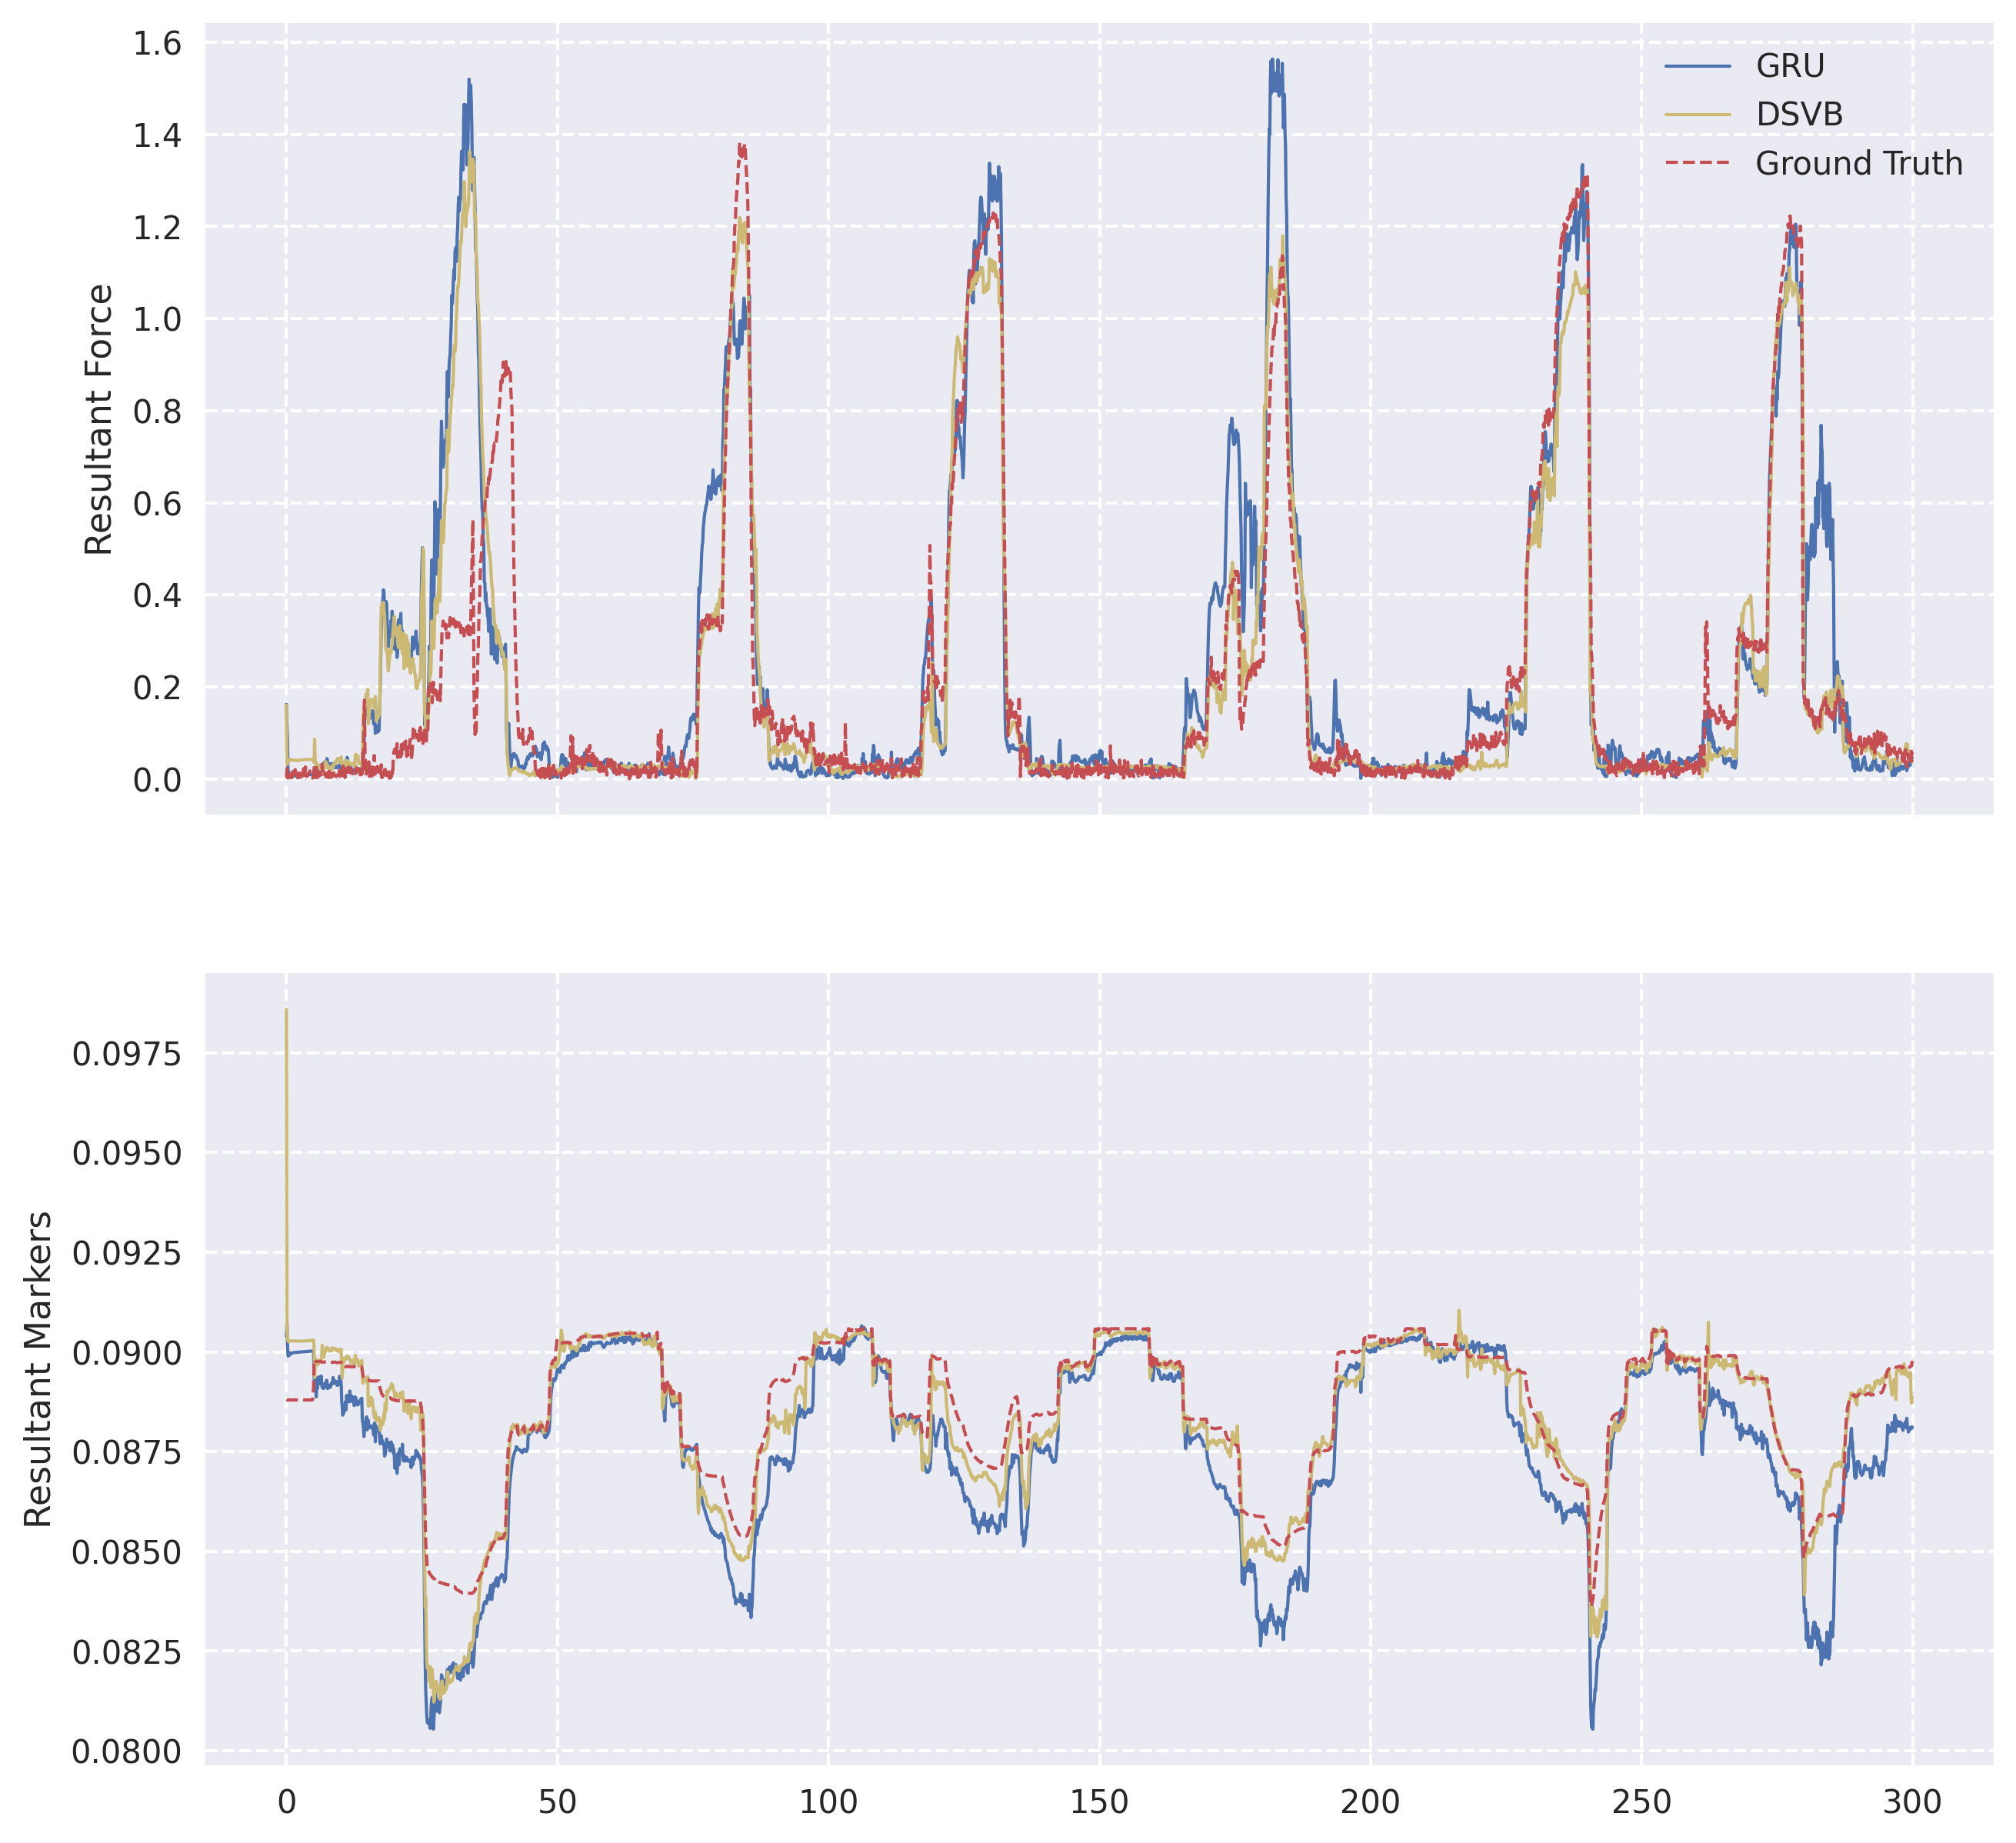

In [83]:
y_test = []
for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
    y_test.append(y_batch_test)

y_test = np.concatenate(y_test)

predicted_arr = scalers[0].inverse_transform(revert_timeseries(y_test, timesteps))
# predicted_arr = revert_timeseries(y_test, timesteps)

resultant_force = np.sqrt( np.square(predicted_arr[:, 0]) + np.square(predicted_arr[:, 1]) )
    
x_tip = predicted_arr[:, 11]
y_tip = predicted_arr[:, -1]
resultant_markers = np.sqrt( np.square(x_tip) + np.square(y_tip) )


labels_arr = [resultant_force, resultant_markers]
# x_title = ["Force X (N)", "Force Z (N)", "X Tip", "Y Tip"]

f, (a1,a2) = plt.subplots(2,1,sharex=True, figsize=(10,10), dpi=300)
# f, (a1,a2,a3,a4) = plt.subplots(4,1,sharex=True)  

a1.set_ylabel('Resultant Force')
a2.set_ylabel('Resultant Markers')
# a3.set_ylabel('X Marker Tip')
# a4.set_ylabel('Y Marker Tip')

x = 0.1*np.arange(np.shape(predicted_arr)[0])

axes = (a1, a2)
labels = ["GRU", "DSVB"]

ESTIMATIONS = []
c = [sns.color_palette()[0], sns.color_palette()[4], sns.color_palette()[1]]
for i, model in enumerate([gru, vrnn_dat]):
    ESTIMATIONS.append(plot(axes, model, test_dataset, l=labels[i], vrnn=True if labels[i] == "DSVB" else False, color=c[i]))
    
a1.plot(x,labels_arr[0], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)
a1.grid(linestyle = '--',)

a2.plot(x, labels_arr[1], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)
a2.grid(linestyle = '--',)

# a3.grid(linestyle = '--',)
# a3.plot(x, labels_arr[2],color=sns.color_palette()[2],  linestyle="--", label='Ground Truth', linewidth=1)

# a4.grid(linestyle = '--',)
# a4.plot(x, labels_arr[3], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)

# a4.set_xlabel("Time (s)")
    
a1.legend()
# a2.legend()
# a3.legend()
# a4.legend()
# plt.savefig("estimations.png")
plt.show()


In [84]:
ground_truth = predicted_arr
ESTIMATIONS[0].shape, ground_truth.shape

((3000, 22), (3000, 22))

In [85]:
from scipy.io import savemat

dic = {"Force_actual": ground_truth[:, :2], "Force_GRU": ESTIMATIONS[0][:, :2], "Force_DSVB": ESTIMATIONS[1][:, :2], \
      "posX_actual": ground_truth[:, 2:12], "posX_GRU": ESTIMATIONS[0][:, 2:12], "posX_DSVB": ESTIMATIONS[1][:, 2:12], \
      "posY_actual": ground_truth[:, 12:], "posY_GRU": ESTIMATIONS[0][:, 12:], "posY_DSVB": ESTIMATIONS[1][:, 12:]}

if train_scenario == "tip_contact":
    scenario = 1
elif train_scenario == "random_contact":
    scenario = 2
elif train_scenario == "osc":
    scenario = 3
else:
    scenario = 4
    
savemat(f"for_video/scenario_{scenario}/{params['TEST'][:-3]}.mat", dic)
print("Saved " + f"for_video/scenario_{scenario}/{params['TEST'][:-3]}.mat")

Saved for_video/scenario_4/osc_tip.mat


In [86]:
# from scipy.io import savemat

# dic = {"Force_actual": ground_truth[:, :2], "Force_GRU": ESTIMATIONS[0][:, :2], "Force_DSVB": ESTIMATIONS[1][:, :2], \
#       "posX_actual": ground_truth[:, 2:12], "posX_GRU": ESTIMATIONS[0][:, 2:12], "posX_DSVB": ESTIMATIONS[1][:, 2:12], \
#       "posY_actual": ground_truth[:, 12:], "posY_GRU": ESTIMATIONS[0][:, 12:], "posY_DSVB": ESTIMATIONS[1][:, 12:]}

# savemat("for_video/scenario_3/rand_rand.mat", dic)

## TSNE

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [14]:
train_dataset, test_dataset, scalers = get_dataset("VRNN_DAT", train_scenario, params['batch_size'])

In [15]:
y_data, labels = [], []
for i, (x,y,state) in enumerate(test_dataset.as_numpy_iterator()):
    y_data.append(y)
    labels.append(state)
y_data = np.concatenate(y_data)[:, -1, :]
labels = np.concatenate(labels)

In [16]:
y_data.shape, labels.shape

((14600, 22), (14600,))

In [17]:
from sklearn.manifold import TSNE

In [18]:
def plot_tsne(encoded_features, labels):
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(encoded_features)

  data_df = pd.DataFrame(tsne_results, columns=['tsne-x', 'tsne-y'])
  data_df['Legend'] = labels

  return data_df.sort_values(["Legend"], ascending=True)

In [19]:
df = plot_tsne(y_data, labels)

/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14600 samples in 0.001s...
[t-SNE] Computed neighbors for 14600 samples in 3.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14600
[t-SNE] Computed conditional probabilities for sample 2000 / 14600
[t-SNE] Computed conditional probabilities for sample 3000 / 14600
[t-SNE] Computed conditional probabilities for sample 4000 / 14600
[t-SNE] Computed conditional probabilities for sample 5000 / 14600
[t-SNE] Computed conditional probabilities for sample 6000 / 14600
[t-SNE] Computed conditional probabilities for sample 7000 / 14600
[t-SNE] Computed conditional probabilities for sample 8000 / 14600
[t-SNE] Computed conditional probabilities for sample 9000 / 14600
[t-SNE] Computed conditional probabilities for sample 10000 / 14600
[t-SNE] Computed conditional probabilities for sample 11000 / 14600
[t-SNE] Computed conditional probabilities for sample 12000 / 14600
[t-SNE] Computed conditional probabilities for sa

In [20]:
rnn_pred = get_estimated_state(rnn, test_dataset)[:, -1, :]
print(rnn_pred.shape)
rnn_df = plot_tsne(rnn_pred, labels)

1/1 [==============================] - 0s 25ms/step
(14600, 22)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14600 samples in 0.001s...


/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 14600 samples in 3.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14600
[t-SNE] Computed conditional probabilities for sample 2000 / 14600
[t-SNE] Computed conditional probabilities for sample 3000 / 14600
[t-SNE] Computed conditional probabilities for sample 4000 / 14600
[t-SNE] Computed conditional probabilities for sample 5000 / 14600
[t-SNE] Computed conditional probabilities for sample 6000 / 14600
[t-SNE] Computed conditional probabilities for sample 7000 / 14600
[t-SNE] Computed conditional probabilities for sample 8000 / 14600
[t-SNE] Computed conditional probabilities for sample 9000 / 14600
[t-SNE] Computed conditional probabilities for sample 10000 / 14600
[t-SNE] Computed conditional probabilities for sample 11000 / 14600
[t-SNE] Computed conditional probabilities for sample 12000 / 14600
[t-SNE] Computed conditional probabilities for sample 13000 / 14600
[t-SNE] Computed conditional probabilities for sample 14000 / 14600

In [21]:
vrnn_dat_pred = get_estimated_state(vrnn_dat, test_dataset)[:, -1, :]
print(vrnn_dat_pred.shape)
vrnn_dat_df = plot_tsne(vrnn_dat_pred, labels)

(14600, 22)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14600 samples in 0.000s...


/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 14600 samples in 3.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14600
[t-SNE] Computed conditional probabilities for sample 2000 / 14600
[t-SNE] Computed conditional probabilities for sample 3000 / 14600
[t-SNE] Computed conditional probabilities for sample 4000 / 14600
[t-SNE] Computed conditional probabilities for sample 5000 / 14600
[t-SNE] Computed conditional probabilities for sample 6000 / 14600
[t-SNE] Computed conditional probabilities for sample 7000 / 14600
[t-SNE] Computed conditional probabilities for sample 8000 / 14600
[t-SNE] Computed conditional probabilities for sample 9000 / 14600
[t-SNE] Computed conditional probabilities for sample 10000 / 14600
[t-SNE] Computed conditional probabilities for sample 11000 / 14600
[t-SNE] Computed conditional probabilities for sample 12000 / 14600
[t-SNE] Computed conditional probabilities for sample 13000 / 14600
[t-SNE] Computed conditional probabilities for sample 14000 / 14600

In [22]:
vrnn_dat_latent = get_latent_measurement(vrnn_dat, test_dataset)[:, -1, :]
print(vrnn_dat_latent.shape)
vrnn_dat_latent_df = plot_tsne(vrnn_dat_latent, labels)

(14600, 32)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14600 samples in 0.001s...


/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/app/python/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 14600 samples in 3.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14600
[t-SNE] Computed conditional probabilities for sample 2000 / 14600
[t-SNE] Computed conditional probabilities for sample 3000 / 14600
[t-SNE] Computed conditional probabilities for sample 4000 / 14600
[t-SNE] Computed conditional probabilities for sample 5000 / 14600
[t-SNE] Computed conditional probabilities for sample 6000 / 14600
[t-SNE] Computed conditional probabilities for sample 7000 / 14600
[t-SNE] Computed conditional probabilities for sample 8000 / 14600
[t-SNE] Computed conditional probabilities for sample 9000 / 14600
[t-SNE] Computed conditional probabilities for sample 10000 / 14600
[t-SNE] Computed conditional probabilities for sample 11000 / 14600
[t-SNE] Computed conditional probabilities for sample 12000 / 14600
[t-SNE] Computed conditional probabilities for sample 13000 / 14600
[t-SNE] Computed conditional probabilities for sample 14000 / 14600

<AxesSubplot:title={'center':'VRNN_DAT Latent'}, xlabel='tsne-x', ylabel='tsne-y'>

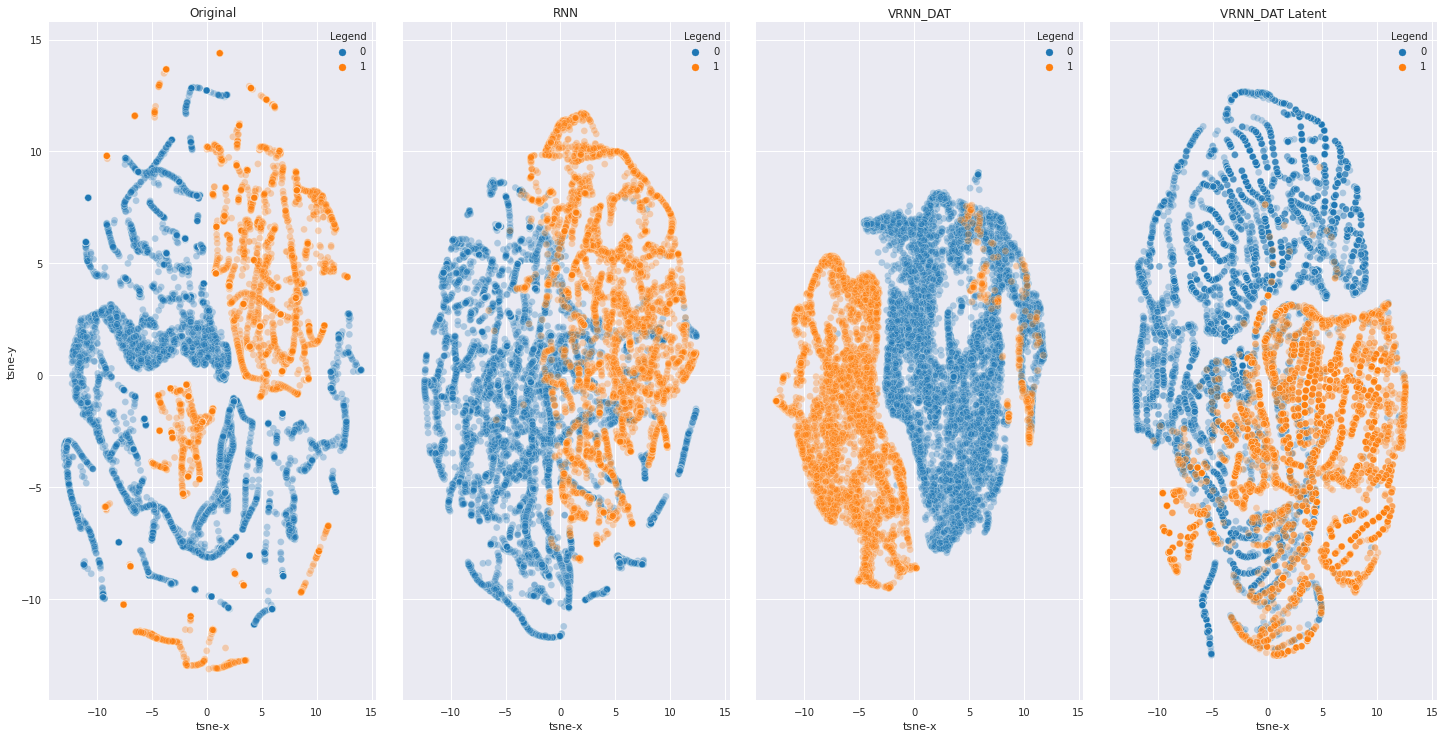

In [23]:
plt.style.use('seaborn')
# f, (a1, a2, a3, a4) = plt.subplots(1,4,sharey=True, sharex=True, figsize=(20, 10))
f, (a1,a2, a3) = pyplot.subplots(1,3,sharey=True, sharex=True, figsize=(20, 5))

plt.rc('axes', titlesize=70)     # fontsize of the axes title

f.tight_layout()

a1.title.set_text("Original")
sns.scatterplot(
x="tsne-x", y="tsne-y",
hue="Legend",
palette=sns.color_palette("tab10", len(df['Legend'].unique())),
data=df,
legend=True,
alpha=0.3,
ax=a1
)

a2.title.set_text("RNN")
sns.scatterplot(
x="tsne-x", y="tsne-y",
hue="Legend",
palette=sns.color_palette("tab10", len(rnn_df['Legend'].unique())),
data=rnn_df,
legend=True,
alpha=0.3,
ax=a2
)

a3.title.set_text("VRNN_DAT")
sns.scatterplot(
x="tsne-x", y="tsne-y",
hue="Legend",
palette=sns.color_palette("tab10", len(vrnn_dat_df['Legend'].unique())),
data=vrnn_dat_df,
legend=True,
alpha=0.3,
ax=a3
)

# a4.title.set_text("VRNN_DAT Latent")
# sns.scatterplot(
# x="tsne-x", y="tsne-y",
# hue="Legend",
# palette=sns.color_palette("tab10", len(vrnn_dat_latent_df['Legend'].unique())),
# data=vrnn_dat_latent_df,
# legend=True,
# alpha=0.3,
# ax=a4
# )